<a href="https://colab.research.google.com/github/TheBottomOfTheDeepDarkOcean/AIO-Exercise/blob/develop/Module4/Logistic%20Regression/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [4]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(
  dataset_path,
  index_col ='id'
)

In [5]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [6]:
def text_normalize(text):
  # Retweet old acronym "RT" removal
  text = re.sub(r'^RT[\s]+', '', text)

  # Hyperlinks removal
  text = re.sub(r'https?:\/\/.*[\ r\n]*', '', text)

  # Hashtags removal
  text = re.sub(r'#', '', text)

  # Punctuation removal
  text = re.sub (r'[^\ w\s]', '', text)

  # Tokenization
  tokenizer = TweetTokenizer(
    preserve_case =False,
    strip_handles =True,
    reduce_len = True
)
  text_tokens = tokenizer.tokenize(text)

  return text_tokens

In [8]:
def get_freqs(df):
  freqs = defaultdict(lambda: 0)
  for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    tokens = text_normalize(tweet)
    for token in tokens:
      pair = (token, label)
      freqs[pair] += 1
  return freqs

In [10]:
import numpy as np
def get_feature(text , freqs ):
  tokens = text_normalize(text)

  X = np.zeros(3)
  X[0] = 1

  for token in tokens:
    X[1] += freqs[(token, 0)]
    X[2] += freqs[(token, 1)]
  return X

In [13]:
X = []
y = []

freqs = get_freqs(df)
for idx , row in df.iterrows():
  tweet = row['tweet']
  label = row['label']

  X_i = get_feature(tweet, freqs)
  X.append(X_i)
  y.append(label)

X = np.array(X)
y = np.array(y)

In [14]:
X

array([[1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 7.185e+03, 2.609e+03],
       ...,
       [1.000e+00, 7.185e+03, 2.609e+03],
       [1.000e+00, 1.437e+04, 5.218e+03],
       [1.000e+00, 7.185e+03, 2.609e+03]])

In [24]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
import pandas as pd

y_series = pd.Series(y)

y_series.value_counts()

,count
0,5894
1,2026


In [25]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (
                                    X, y,
                                    test_size = val_size,
                                    random_state = random_state,
                                    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
                                    X_train , y_train,
                                    test_size = test_size ,
                                    random_state = random_state,
                                    shuffle = is_shuffle
)

In [26]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[: , 1:] = normalizer.transform(X_test[:, 1:])

In [28]:
def sigmoid (z) :
  return 1 / (1 + np.exp(-z))

def compute_loss(y_hat, y):
  y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

  return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat )).mean()

def predict(X, theta):
  dot_product = np.dot(X, theta)
  y_hat = sigmoid(dot_product)
  return y_hat

def compute_gradient(X, y, y_hat):
  return np.dot(X.T, ( y_hat - y)) / y. size

def update_theta (theta, gradient, lr):
  return theta - lr * gradient

def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta).round()
  acc = (y_hat == y).mean()
  return acc

In [29]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size = X_train.shape[1])

In [30]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_losses = []
  train_batch_accs = []
  val_batch_losses = []
  val_batch_accs = []

  for i in range (0 , X_train . shape [0] , batch_size ) :
    X_i = X_train[i : i + batch_size]
    y_i = y_train[i : i + batch_size]

    y_hat = predict(X_i, theta)

    train_loss = compute_loss(y_hat, y_i)

    gradient = compute_gradient(X_i, y_i, y_hat)

    theta = update_theta(theta, gradient, lr)

    train_batch_losses.append(train_loss)

    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  val_losses.append(val_batch_loss)
  train_accs.append(train_batch_acc)
  val_accs.append(val_batch_acc)
  print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')



EPOCH 1:	Training loss: 0.824	Validation loss: 0.825

EPOCH 2:	Training loss: 0.773	Validation loss: 0.774

EPOCH 3:	Training loss: 0.733	Validation loss: 0.733

EPOCH 4:	Training loss: 0.700	Validation loss: 0.700

EPOCH 5:	Training loss: 0.674	Validation loss: 0.674

EPOCH 6:	Training loss: 0.654	Validation loss: 0.654

EPOCH 7:	Training loss: 0.638	Validation loss: 0.638

EPOCH 8:	Training loss: 0.625	Validation loss: 0.625

EPOCH 9:	Training loss: 0.614	Validation loss: 0.615

EPOCH 10:	Training loss: 0.606	Validation loss: 0.607

EPOCH 11:	Training loss: 0.600	Validation loss: 0.601

EPOCH 12:	Training loss: 0.594	Validation loss: 0.596

EPOCH 13:	Training loss: 0.590	Validation loss: 0.592

EPOCH 14:	Training loss: 0.587	Validation loss: 0.588

EPOCH 15:	Training loss: 0.584	Validation loss: 0.585

EPOCH 16:	Training loss: 0.581	Validation loss: 0.583

EPOCH 17:	Training loss: 0.579	Validation loss: 0.581

EPOCH 18:	Training loss: 0.578	Validation loss: 0.580

EPOCH 19:	Training

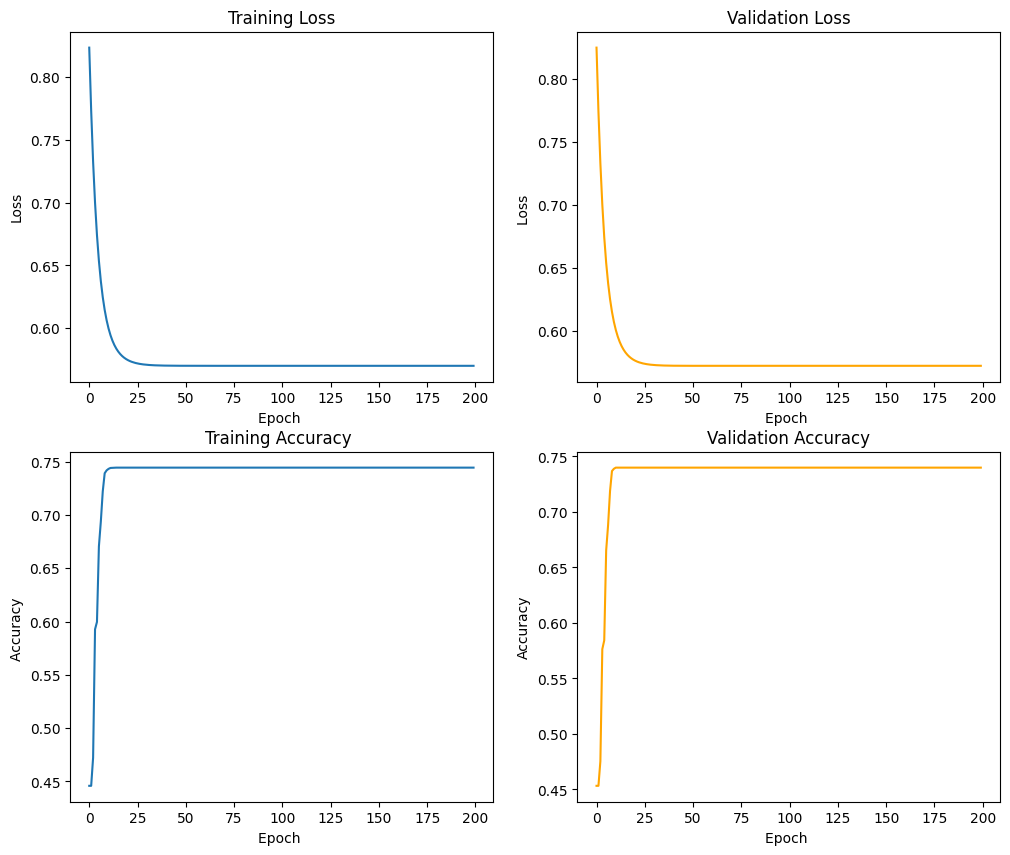

In [31]:
fig, ax = plt.subplots(2, 2, figsize =(12 , 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel = 'Epoch ', ylabel = 'Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel = 'Epoch ', ylabel = 'Loss ')
ax[0 , 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel = 'Epoch ', ylabel ='Accuracy ')
ax[1, 0].set_title('Training Accuracy ')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel ='Epoch ', ylabel ='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [32]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set :')
print(f'Accuracy : {val_set_acc}')
print(f'Accuracy : {test_set_acc}')

Evaluation on validation and test set :
Accuracy : 0.73989898989899
Accuracy : 0.7512626262626263
